In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


In [199]:
df = pd.read_csv("train.csv")

In [200]:
df.groupby('LotArea')['LotFrontage'].mean()

LotArea
1300       24.0
1477       21.0
1491       21.0
1526       21.0
1533       21.0
          ...  
70761      62.0
115149      NaN
159000      NaN
164660      NaN
215245    150.0
Name: LotFrontage, Length: 1073, dtype: float64

In [223]:
%timeit b = df.groupby(['MSSubClass', "Neighborhood"])['KitchenQual'].transform(lambda x: x.fillna(x.mode()))

105 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [208]:
c = df.groupby(['MSSubClass', "Neighborhood"])['KitchenQual'].transform(lambda x: x.mode()[0])

In [220]:
(b==a).all()

True

In [224]:
%timeit a = df['KitchenQual'].fillna((df.groupby(['MSSubClass', "Neighborhood"])['KitchenQual'].transform(lambda x: x.mode()[0])))

40.2 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [128]:
Q1 = df.quantile(0.25, numeric_only=True)
Q3 = df.quantile(0.75, numeric_only=True)
IQS = Q3 - Q1

outliers = ((df[IQS.index] < Q1 - 1.5*IQS) | (df[IQS.index] > Q3 + 1.5*IQS)).any(axis=1)
df = df[~outliers]

<Axes: >

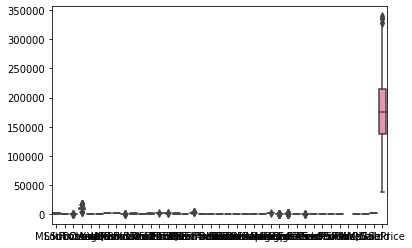

In [26]:
sns.boxplot(df)

In [27]:
df['Has_pool'] = df['PoolArea'].astype(bool).astype(int)
df['Has_alley_access'] = (~df['Alley'].isna()).astype(int)
df['Has_garage'] = (~df['GarageQual'].isna()).astype(int)

qual = dict(zip(["Po", "Fa", "TA", "Gd", "Ex"], range(1, 6)))
df['ExterQual'] = df['ExterQual'].apply(lambda x: qual[x])
df['ExterCond'] = df['ExterCond'].apply(lambda x: qual[x])
df['BsmtQual'].fillna(0, inplace=True)
df['BsmtCond'].fillna(0, inplace=True)
df['BsmtQual'] = df['BsmtQual'].apply(lambda x: qual[x] if x else x)
df['BsmtCond'] = df['BsmtCond'].apply(lambda x: qual[x] if x else x)
df['Has_2story'] = df['HouseStyle'].apply(lambda x: '2' in x)

df['HeatingQC'] = df['HeatingQC'].apply(lambda x: qual[x])
df['KitchenQual'] = df['KitchenQual'].apply(lambda x: qual[x])
df['FireplaceQu'].fillna(0, inplace=True)
df['FireplaceQu'] = df['FireplaceQu'].apply(lambda x: qual[x] if x else x)
df['GarageQual'].fillna(0, inplace=True)
df['GarageQual'] = df['GarageQual'].apply(lambda x: qual[x] if x else x)
df['GarageCond'].fillna(0, inplace=True)
df['GarageCond'] = df['GarageCond'].apply(lambda x: qual[x] if x else x)
df['PoolQC'].fillna(0, inplace=True)
df['PoolQC'] = df['PoolQC'].apply(lambda x: qual[x] if x else x)


Exposure = dict(zip(('No', 'Mn', "Av", 'Gd'), range(1, 5)))
df['BsmtExposure'].fillna(0, inplace=True)
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda x: Exposure[x] if x else x)


Rating = dict(zip(('Unf', 'LwQ', "Rec", 'BLQ', 'ALQ', 'GLQ'), range(1, 7)))
df['BsmtFinType1'].fillna(0, inplace=True)
df['BsmtFinType2'].fillna(0, inplace=True)
df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda x: Rating[x] if x else x)
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda x: Rating[x] if x else x)

df['CentralAir'] = (df['CentralAir']=='Y').astype(int)
df['PavedDrive'] = (df['PavedDrive']!='N').astype(int)


df.drop(columns=['Id', 'Alley', 'Fence', 'MiscFeature', 'GarageFinish',
                'Neighborhood', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle',
                'RoofMatl', 'Exterior1st', 'Exterior2nd','Functional','MoSold', 'YrSold', 'Condition1', 'Condition2', 'Electrical'], inplace=True)

df.dropna(inplace=True)

In [28]:
df_dummies = pd.get_dummies(df)

<Axes: >

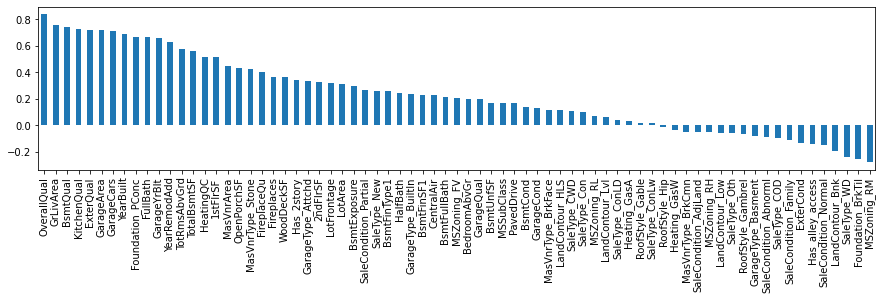

In [29]:
df_dummies.corr()['SalePrice'].sort_values(ascending=False)[1:74].plot.bar(figsize=(15,3))

<Axes: >

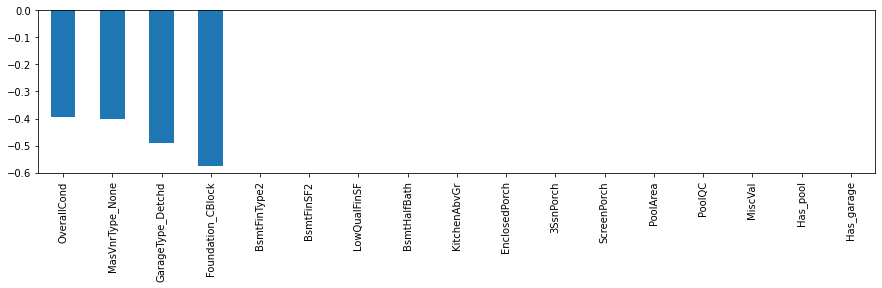

In [30]:
df_dummies.corr()['SalePrice'].sort_values(ascending=False)[74:].plot.bar(figsize=(15,3))

#### Preprocessing

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummies.drop(columns='SalePrice')
y = df_dummies['SalePrice']

features = X.columns.values

Scaler = MinMaxScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X)
X.columns = features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

metrics.mean_squared_error(y_test, prediction)

1.0711787023298387e+31

In [39]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

metrics.mean_squared_error(y_test, prediction)

505082726.3484604

In [40]:
model.score(X_train, y_train)

0.9999980218864016

In [41]:
model.score(X_test, y_test)

0.8331725949849176

In [37]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(1000, activation='relu'),
    Dense(500, activation='relu'),
    Dense(200, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(optimizer=Adam(), loss=MeanSquaredError())
model.fit(X_train, y_train, epochs=100)

2023-07-24 14:26:00.812445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-24 14:26:00.812477: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-24 14:26:01.578804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-24 14:26:01.578925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-24 14:26:01.578937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

Epoch 1/100


2023-07-24 14:26:02.487022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-24 14:26:02.487059: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-24 14:26:02.487086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (seshdesktop): /proc/driver/nvidia/version does not exist


11/11 [==============================] - 1s 17ms/step - loss: 37406076928.0000
Epoch 2/100
11/11 [==============================] - 0s 16ms/step - loss: 37324853248.0000
Epoch 3/100
11/11 [==============================] - 0s 16ms/step - loss: 36889899008.0000
Epoch 4/100
11/11 [==============================] - 0s 15ms/step - loss: 35387953152.0000
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 31572799488.0000
Epoch 6/100
11/11 [==============================] - 0s 17ms/step - loss: 23829411840.0000
Epoch 7/100
11/11 [==============================] - 0s 21ms/step - loss: 12324026368.0000
Epoch 8/100
11/11 [==============================] - 0s 18ms/step - loss: 2903619328.0000
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 1747651584.0000
Epoch 10/100
11/11 [==============================] - 0s 18ms/step - loss: 1256289536.0000
Epoch 11/100
11/11 [==============================] - 0s 17ms/step - loss: 1087196160.0000
Epoch 12/100


11/11 [==============================] - 0s 21ms/step - loss: 322000096.0000
Epoch 93/100
11/11 [==============================] - 0s 17ms/step - loss: 322630368.0000
Epoch 94/100
11/11 [==============================] - 0s 16ms/step - loss: 319837472.0000
Epoch 95/100
11/11 [==============================] - 0s 17ms/step - loss: 320628992.0000
Epoch 96/100
11/11 [==============================] - 0s 16ms/step - loss: 320393632.0000
Epoch 97/100
11/11 [==============================] - 0s 17ms/step - loss: 323327552.0000
Epoch 98/100
11/11 [==============================] - 0s 16ms/step - loss: 332215232.0000
Epoch 99/100
11/11 [==============================] - 0s 17ms/step - loss: 311431520.0000
Epoch 100/100
11/11 [==============================] - 0s 20ms/step - loss: 309633376.0000


In [38]:
prediciton = model.predict(X_test)
metrics.mean_squared_error(y_test, prediciton)

3/3 [==============================] - 0s 5ms/step


652912790.7674575

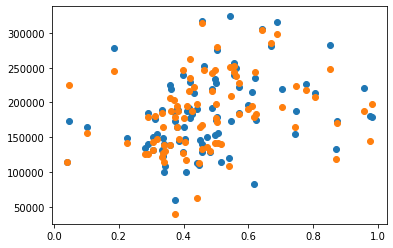

In [42]:
plt.scatter(X_test['LotArea'], y_test)
plt.scatter(X_test['LotArea'], prediction)

In [43]:
df = pd.read_csv('test.csv')

In [44]:
df['Has_pool'] = df['PoolArea'].astype(bool).astype(int)
df['Has_alley_access'] = (~df['Alley'].isna()).astype(int)
df['Has_garage'] = (~df['GarageQual'].isna()).astype(int)

qual = dict(zip(["Po", "Fa", "TA", "Gd", "Ex"], range(1, 6)))
df['ExterQual'] = df['ExterQual'].apply(lambda x: qual[x])
df['ExterCond'] = df['ExterCond'].apply(lambda x: qual[x])
df['BsmtQual'].fillna(0, inplace=True)
df['BsmtCond'].fillna(0, inplace=True)
df['BsmtQual'] = df['BsmtQual'].apply(lambda x: qual[x] if x else x)
df['BsmtCond'] = df['BsmtCond'].apply(lambda x: qual[x] if x else x)
df['Has_2story'] = df['HouseStyle'].apply(lambda x: '2' in x)

df['HeatingQC'] = df['HeatingQC'].apply(lambda x: qual[x])
df['KitchenQual'].fillna(0, inplace=True)
df['KitchenQual'] = df['KitchenQual'].apply(lambda x: qual[x] if x else x)
df['FireplaceQu'].fillna(0, inplace=True)
df['FireplaceQu'] = df['FireplaceQu'].apply(lambda x: qual[x] if x else x)
df['GarageQual'].fillna(0, inplace=True)
df['GarageQual'] = df['GarageQual'].apply(lambda x: qual[x] if x else x)
df['GarageCond'].fillna(0, inplace=True)
df['GarageCond'] = df['GarageCond'].apply(lambda x: qual[x] if x else x)
df['PoolQC'].fillna(0, inplace=True)
df['PoolQC'] = df['PoolQC'].apply(lambda x: qual[x] if x else x)


Exposure = dict(zip(('No', 'Mn', "Av", 'Gd'), range(1, 5)))
df['BsmtExposure'].fillna(0, inplace=True)
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda x: Exposure[x] if x else x)


Rating = dict(zip(('Unf', 'LwQ', "Rec", 'BLQ', 'ALQ', 'GLQ'), range(1, 7)))
df['BsmtFinType1'].fillna(0, inplace=True)
df['BsmtFinType2'].fillna(0, inplace=True)
df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda x: Rating[x] if x else x)
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda x: Rating[x] if x else x)

df['CentralAir'] = (df['CentralAir']=='Y').astype(int)
df['PavedDrive'] = (df['PavedDrive']!='N').astype(int)


df.drop(columns=['Alley', 'Fence', 'MiscFeature', 'GarageFinish',
                'Neighborhood', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle',
                'RoofMatl', 'Exterior1st', 'Exterior2nd','Functional','MoSold', 'YrSold','Condition1', 'Condition2', 'Electrical'], inplace=True)

#df.dropna(inplace=True)
df.sort_values(by='LotArea', inplace=True)
df.fillna(method='ffill', inplace=True)
df.sort_values(by='Id', inplace=True)


In [45]:
X_contest = pd.get_dummies(df)[features]

In [46]:
y_contest = model.predict(X_contest)

In [47]:
output = pd.DataFrame({'Id':df['Id'], 'SalePrice':y_contest})

In [49]:
output.to_csv('submission.csv', index=False)

In [50]:
len(df)

1459

In [55]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,SaleType,SaleCondition,Has_pool,Has_alley_access,Has_garage,Has_2story
0,1461,20,RH,80.0,11622,Lvl,5,6,1961,1961,Gable,None,0.0,3,3,CBlock,3,3,1,3,468.0,2,144.0,270.0,882.0,GasA,3,1,896,0,0,896,0.0,0.0,1,0,2,1,3,5,0,0,Attchd,1961.0,1.0,730.0,3,3,1,140,0,0,0,120,0,0,0,WD,Normal,0,0,1,False
1,1462,20,RL,81.0,14267,Lvl,6,6,1958,1958,Hip,BrkFace,108.0,3,3,CBlock,3,3,1,5,923.0,1,0.0,406.0,1329.0,GasA,3,1,1329,0,0,1329,0.0,0.0,1,1,3,1,4,6,0,0,Attchd,1958.0,1.0,312.0,3,3,1,393,36,0,0,0,0,0,12500,WD,Normal,0,0,1,False
2,1463,60,RL,74.0,13830,Lvl,5,5,1997,1998,Gable,None,0.0,3,3,PConc,4,3,1,6,791.0,1,0.0,137.0,928.0,GasA,4,1,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,1,3,Attchd,1997.0,2.0,482.0,3,3,1,212,34,0,0,0,0,0,0,WD,Normal,0,0,1,True
3,1464,60,RL,78.0,9978,Lvl,6,6,1998,1998,Gable,BrkFace,20.0,3,3,PConc,3,3,1,6,602.0,1,0.0,324.0,926.0,GasA,5,1,926,678,0,1604,0.0,0.0,2,1,3,1,4,7,1,4,Attchd,1998.0,2.0,470.0,3,3,1,360,36,0,0,0,0,0,0,WD,Normal,0,0,1,True
4,1465,120,RL,43.0,5005,HLS,8,5,1992,1992,Gable,None,0.0,4,3,PConc,4,3,1,5,263.0,1,0.0,1017.0,1280.0,GasA,5,1,1280,0,0,1280,0.0,0.0,2,0,2,1,4,5,0,0,Attchd,1992.0,2.0,506.0,3,3,1,0,82,0,0,144,0,0,0,WD,Normal,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Lvl,4,7,1970,1970,Gable,None,0.0,3,3,CBlock,3,3,1,1,0.0,1,0.0,546.0,546.0,GasA,4,1,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,0,0,CarPort,1970.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,WD,Normal,0,0,0,True
1455,2916,160,RM,21.0,1894,Lvl,4,5,1970,1970,Gable,None,0.0,3,3,CBlock,3,3,1,3,252.0,1,0.0,294.0,546.0,GasA,3,1,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,0,0,CarPort,1970.0,1.0,286.0,3,3,1,0,24,0,0,0,0,0,0,WD,Abnorml,0,0,1,True
1456,2917,20,RL,160.0,20000,Lvl,5,7,1960,1996,Gable,None,0.0,3,3,CBlock,3,3,1,5,1224.0,1,0.0,0.0,1224.0,GasA,5,1,1224,0,0,1224,1.0,0.0,1,0,4,1,3,7,1,3,Detchd,1960.0,2.0,576.0,3,3,1,474,0,0,0,0,0,0,0,WD,Abnorml,0,0,1,False
1457,2918,85,RL,62.0,10441,Lvl,5,5,1992,1992,Gable,None,0.0,3,3,PConc,4,3,3,6,337.0,1,0.0,575.0,912.0,GasA,3,1,970,0,0,970,0.0,1.0,1,0,3,1,3,6,0,0,Attchd,2007.0,0.0,0.0,0,0,1,80,32,0,0,0,0,0,700,WD,Normal,0,0,0,False


In [56]:
df['BsmtQual']

0       3
1       3
2       4
3       3
4       4
       ..
1454    3
1455    3
1456    3
1457    4
1458    4
Name: BsmtQual, Length: 1459, dtype: int64

In [225]:
import numpy as np

In [226]:
x = np.linspace(0, 100)

In [227]:
np.std(x)

29.45075446869758